In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from scipy.special import comb, factorial
from itertools import combinations, product
import pickle

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from ipywidgets import widgets, interact, interactive
from IPython.display import display

%matplotlib inline

Helper functions

In [2]:
def plot_stim(stim, *args, **kwargs):
        plt.scatter(*np.where(stim)[::-1], marker='|', *args, **kwargs)

An implementation of the discrete form of the "Tempotron" classifier - https://www.nature.com/articles/nn1643  
Using tensorflow.  
This version attempt to learn from multiple samples in one "Go", following the previous success with the single sample version

Initial parameter setting

In [3]:
sess = tf.InteractiveSession()
### Parameter settings
m = 1000 # Number of samples to generate
n = 10 # Number of neurons in each sample
t = 500 # Number of 1ms long time bins

threshold_value = 4 # Threshold for activation in each time bin

rand_freq = 25
def gen_random_trains(freq, m, shape):
    # np.random.seed(0)
    # Generating random samples
    rand_trains = np.random.binomial(1, freq/1000 ,(m, *shape))

    # Random label assignment
    frac = 0.5 # Fraction of samples for which a "1" label is assigned
    rand_labels = np.random.binomial(1, frac, m).astype(bool)
    
    return (rand_trains, rand_labels)
rand_trains, rand_labels = gen_random_trains(rand_freq, m, (n, t))

### Model definition

In [4]:
# Model input and initial weight setting
x = tf.placeholder(tf.float32, shape=(None, n, t)) # Input layer
w = tf.Variable(
    tf.random_uniform(shape=(1, n), minval=0, maxval=1)) # Weight initialization

# Real labels
y_ = tf.placeholder(tf.bool) 

# Activation threshold node
thresh = tf.constant(threshold_value, dtype=tf.float32) 

# Activation layer
h = tf.squeeze(tf.tensordot(w, x, [[1],[1]]))
a_h = tf.tensordot(w,x, [[1],[1]])

# Thresholding activation
h_t = tf.greater_equal(h, thresh)
a_h_t = tf.greater_equal(a_h, thresh)

# Decision node
y = tf.reduce_any(h_t, axis=1)
a_y = tf.reduce_any(a_h_t, axis=2)

# Correctly classified samples
correct = tf.equal(y, y_)
a_c = tf.equal(a_y, y_)

Pre-Training assesment

In [6]:
tf.global_variables_initializer().run()
fd = {x: rand_trains, y_: rand_labels}
print('Weight Vector:\n {}'.format(w.eval()))
c = []
for _ in range(100):
    tf.global_variables_initializer().run()
    c_temp = correct.eval(fd)
    c.append(c_temp.sum()/c_temp.size)
print('{:.2%} ± {:.2%}'.format(np.mean(c), np.std(c, ddof=0)))

Weight Vector:
 [[ 0.11457229  0.57607234  0.73511159  0.32524776  0.05296302  0.92618799
   0.81590438  0.53317499  0.46745205  0.94566405]]
45.21% ± 0.04%


### Training definition

In [5]:
# Define learning rate
learning_rate = 1

lmbda = tf.constant(learning_rate, dtype=tf.float32)

# Filter for only wrong trials
wrong_trials = tf.where(~correct)[:, 0]
a_w = tf.where(~a_c)[:, 1]

xfilt = tf.gather(x, wrong_trials, axis=0)
a_xfilt = tf.gather(x, a_w, axis=0)
hfilt = tf.gather(h, wrong_trials, axis=0)
a_hfilt = tf.gather(a_h, a_w, axis=1)

# Select parameters for variable update
strongest_node = tf.argmax(hfilt, axis=1)
a_str = tf.argmax(a_hfilt, axis=2)

inds = tf.stack(
    [tf.range(tf.size(strongest_node, out_type=tf.int64)), strongest_node],
    axis=1)
a_inds = tf.stack(
[tf.range(tf.size(a_str[0,:], out_type=tf.int64)), a_str[0,:]],
    axis=1)

x_upd = tf.gather_nd(tf.transpose(xfilt, [0,2,1]), inds)
a_xup = tf.gather_nd(tf.transpose(a_xfilt, [0,2,1]), a_inds)

y__upd = tf.cast(tf.gather(y_, wrong_trials), x_upd.dtype)[:, np.newaxis]
a_yup = tf.cast(tf.gather(y_, a_w), a_xup.dtype)[:, np.newaxis]

# weight update
w_upd = tf.reduce_sum(lmbda * (2 * y__upd - 1) * x_upd, 0)
a_wupd = tf.reduce_sum(lmbda * (2 * a_yup - 1) * a_xup , 0)

train_step = tf.assign(w, tf.add(w, w_upd))
a_trn = tf.assign(w, tf.add(w, a_wupd))


Actual  training

In [ ]:
batch_size = 30 
iter_num = 1000
def train(data, labels, batch_size, iter_num):
    for _ in range(iter_num):
        # This is techincally problematic because of sampling with replacement in index selection
        inp_inds = np.random.randint(m, size=batch_size, dtype=int)
        fd = {x: data[inp_inds], y_: labels[inp_inds]}
        sess.run(train_step, fd)

c_p = []
for _ in range(30):
    tf.global_variables_initializer().run()
    train(rand_trains, rand_labels, batch_size, iter_num)
    fd = {x: rand_trains, y_: rand_labels}
    c = correct.eval(fd)
    c_p.append(c.sum()/c.size)
    
print('Weight Vector:\n {}'.format(w.eval()))
print('{:.2%} ± {:.2%}'.format(np.mean(c_p), np.std(c_p, ddof=0)))

Creating shifted samples

In [7]:
rinds = np.random.choice(range(rand_trains.shape[0]), size=2)
stim_a, stim_b = rand_trains[rinds]
n_shifted = 500
shiftlen = 5
def make_basic_shifted(a, b, shiftlen, n_shifted):
    
    a_shifted, b_shifted = [np.zeros((n_shifted, *a.shape))] * 2

    a_times = np.where(a)
    b_times = np.where(b)

    a_shifts = np.random.randint(-shiftlen, shiftlen+1, 
                                 size=(n_shifted, *a_times[0].shape))
    a_new = a_times[1] + a_shifts
    a_new[a_new < 0] = 0
    a_new[a_new >= n_shifted] = n_shifted-1

    b_shifts = np.random.randint(-shiftlen, shiftlen+1, 
                                 size=(n_shifted, *b_times[0].shape))
    b_new = b_times[1] + b_shifts
    b_new[b_new < 0] = 0
    b_new[b_new >= n_shifted] = n_shifted-1

    #### NEEDS ATTENTION
    for i in range(n_shifted):
        a_shifted[i, a_times[0], a_new[i]] = 1
        b_shifted[i, b_times[0], b_new[i]] = 1
    stims = np.concatenate([a_shifted, b_shifted])
    labels = [*[0]*n_shifted, *[1]*n_shifted]

    inds = np.arange(1000)
    np.random.shuffle(inds)

    stims = stims[inds]
    labels = np.array(labels, dtype=bool)[inds]
    return (stims, labels)
stims, labels = make_basic_shifted(stim_a, stim_b, 4, 500)


In [20]:
rinds = np.random.choice(range(rand_trains.shape[0]), size=2)
stim_a, stim_b = rand_trains[rinds]

a_shifted, b_shifted = [np.zeros((n_shifted, *stim_a.shape))] * 2

a_times = np.where(stim_a)


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int64),
 array([ 33,  41,  56,  59,  85,  89,  99, 182, 184, 210, 212, 300, 381,
        406,  37,  62, 105, 117, 169, 176, 189, 211, 233, 269, 315, 352,
        403, 414, 435, 457, 462,   1,  20,  95, 270, 353, 369, 431, 446,
        464, 475,   3,  59,  85, 125, 168, 177, 197, 213, 239, 277, 334,
        364, 386, 401, 458, 478, 489,   8,  87, 144, 178, 197, 205, 250,
        278,  17,  20,  26,  83,  86,  89, 148, 189, 214, 227, 321, 377,
        438, 495,  16, 103, 137, 268, 283, 321, 410, 487, 126, 132, 135,
        177, 211, 282, 415, 449, 494, 497,

In [121]:
shiftlen = 4
a = stim_a
a_shifted, b_shifted = [np.zeros((n_shifted, *stim_a.shape))] * 2
a_times = np.where(a)
a_shifts = np.random.randint(-shiftlen, shiftlen+1, 
                                 size=(n_shifted, *a_times[0].shape))
a_new = a_times[1] + a_shifts
n_shifted = 500
a_new[a_new < 0] = 0
a_new[a_new >= n_shifted] = n_shifted-1
for i in range(n_shifted):
        a_shifted[i, a_times[0], a_new[i]] = 1
a_shifted.sum(2)
        

array([[ 25.,  19.,  23., ...,  23.,  20.,  21.],
       [ 26.,  18.,  23., ...,  23.,  19.,  20.],
       [ 26.,  19.,  22., ...,  22.,  19.,  21.],
       ..., 
       [ 26.,  19.,  22., ...,  23.,  20.,  21.],
       [ 26.,  19.,  23., ...,  22.,  20.,  19.],
       [ 25.,  19.,  23., ...,  22.,  17.,  20.]])

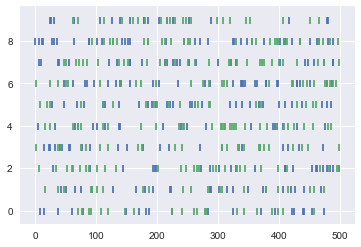

In [91]:
plt.subplot(121)
plot_stim(stim_a)
plot_stim(stim_b)
plt.subplot(122)

Encapsulating model

In [141]:
class Tempotron():
    def __init__(self, threshold_value, learning_rate,
                input_shape=(10, 500), weights=None, reduce_func='sum'):
        # Handling input
        if len(np.shape(input_shape)) == 0: # This is for future use when input shapes are generalized
            input_shape = (input_shape, )
        self.threshold_value = threshold_value
        self.learning_rate = learning_rate
        self.input_shape = input_shape
        self.weights = weights
        
        # Model constants
        self.thresh = tf.constant(threshold_value, dtype=tf.float32)
        self.lmbda = tf.constant(learning_rate, dtype=tf.float32)
        
        # Instantiating the model
        self.reduce_func = getattr(tf, 'reduce_{}'.format(reduce_func)) # Setting reduce function for weight updates
        self.setup_model()
        self.setup_training()
        self.start_session()
        
    def start_session(self):
        self.sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()
        
    def initvals(self):
        tf.global_variables_initializer().run()
        
    def setup_model(self):
        # Input layer
        self.x = tf.placeholder(tf.float32, shape=(None, *self.input_shape))
        
        # Configurable weights - Must manually define weights with proper shape!
        if self.weights == None:
            # Weight initialization # Currently fixed for N x T shapes
            self.w = tf.Variable(
                tf.random_uniform(shape=(1, self.input_shape[0]), minval=0, maxval=1))
        elif type(self.weights) == tf.Variable:
            self.w = self.weights
        else:
            self.w = tf.Variable(self.weights)
            
        # Activation layer - NOTE: CURRENTLY NOT GENERALIZED TO ANY SHAPE!
        ## NEED TO SWITCH TO A VERSION WITH NO SQUEEZE!
        self.h = tf.tensordot(self.w, self.x, [[1],[1]])
        
        # Thresholding activation
        self.h_t = tf.greater_equal(self.h, self.thresh)

        # Decision node
        self.y = tf.reduce_any(self.h_t, axis=2)
        
        # Real labels
        self.y_ = tf.placeholder(tf.bool)
        
        # Correctly classified samples
        self.correct = tf.equal(self.y, self.y_)
        
    def setup_training(self):
        ### This should return a self.train_step object for use in the training 
        ### phase, currently fixed method
        
        # Filter for only wrong trials
        self.wrong_trials = tf.where(~self.correct)[:, 1]

        self.xfilt = tf.gather(self.x, self.wrong_trials, axis=0)
        self.hfilt = tf.gather(self.h, self.wrong_trials, axis=1)

        # Select parameters for variable update
        self.strongest_node = tf.argmax(self.hfilt, axis=2)

        self.inds = tf.stack(
            [tf.range(tf.size(self.strongest_node[0, :], out_type=tf.int64)), self.strongest_node[0, :]],
            axis=1)
        self.x_upd = tf.gather_nd(tf.transpose(self.xfilt, [0,2,1]), self.inds)

        self.y__upd = tf.cast(tf.gather(self.y_, self.wrong_trials), self.x_upd.dtype)[:, np.newaxis]

        # weight update
        self.w_upd = self.reduce_func(self.lmbda * (2 * self.y__upd - 1) * self.x_upd, 0)

        self.train_step = tf.assign(self.w, tf.add(self.w, self.w_upd))

    def train(self, data, labels, iter_num=1000, batch_size=None, train_mode='batch', 
              return_params=False, verbose=False):
        '''
        The tempotron training function,
        This function takes data and real labels as input, and trains the model using these samples.
        
        has two alternative 'train_mode' options:
        'batch' : Each training step will run 'batch_size' samples in parallel, 'iter_num' such steps take place
        'single' : Each training step runs on precisely one sample, 'iter_num' repetitions over all samples take place
        '''
        def make_dict(pnames, plist, indlist):
            d = {n: [] for n in pnames}
            d['batch_inds'] = []
            for row, inds in zip(plist, indlist):
                for n, i in zip(pnames, range(len(pnames))):
                        d[n].append(row[i])
                d['batch_inds'].append(inds)
            d['w'] = np.subtract(np.squeeze(d['w']), d['w_upd'])
            d['correct'] = np.mean(d['correct'], 2)
            return d
        
        if return_params:
            pnames = ['w', 'correct', 'w_upd']
            var_list = [getattr(self, n) for n in pnames]
            param_list = []
            
        if train_mode == 'batch':
            if batch_size == None:
                # All iterations use all of the samples
                for i in range(iter_num):
                    fd = {self.x: data, self.y_: labels}
                    if return_params:
                        param_list.append(self.sess.run([*var_list, self.train_step], fd))
                    else:
                        self.sess.run(self.train_step, fd)
                if return_params:
                    params = make_dict(pnames, param_list, indlist=iter_num*[np.arange(data.shape[0])])
                    params['w_post'] = [p[-1] for p in param_list]
                    
            else:
                # Each iteration gets a random subset with size=batch_size
                all_inds = []
                for i in range(iter_num):
                    # This is techincally problematic because of sampling with replacement in index selection
                    inp_inds = np.random.randint(data.shape[0], size=batch_size, dtype=int)
                    fd = {self.x: data[inp_inds], self.y_: labels[inp_inds]}
                    if return_params:
                        all_inds.append(inp_inds)
                        param_list.append(self.sess.run([*var_list, self.train_step], fd))
                    else:
                        self.sess.run(self.train_step, fd)
                if return_params:
                    params = make_dict(pnames, param_list, indlist=all_inds)
                    params['w_post'] = [p[-1] for p in param_list]
                    
        elif train_mode == 'single':
            all_inds = []
            for i in range(iter_num):
                j = 0
                for d, l in zip(data, labels):
                    j += 1
                    fd = {self.x: d[np.newaxis, ], self.y_: l[np.newaxis, ]}
                    if return_params:
                        all_inds.append([j])
                        param_list.append(self.sess.run([*var_list, self.train_step], fd))
                    else:
                        self.sess.run(self.train_step, fd)
            if return_params:
                params = make_dict(pnames, param_list, indlist=all_inds)
                params['w_post'] = [p[-1] for p in param_list]
                        
        if return_params:
            return params
        
    def accuracy(self, data, labels):
        fd = {self.x: data, self.y_: labels}
        c = self.correct.eval(fd)
        return c.sum()/c.size

In [9]:
# Run this for the shifted data
thresh = 1.5
learning_rate = 1e-4
tmp = Tempotron(thresh, learning_rate)
tmp.reduce_func = tf.reduce_mean
data_all = tmp.train(rand_trains, rand_labels, train_mode='batch', return_params=True)
tmp.initvals()
data_50 = tmp.train(rand_trains, rand_labels, batch_size=50, return_params=True)
tmp.initvals()
data_s = tmp.train(rand_trains, rand_labels, iter_num=50, train_mode='single', return_params=True)

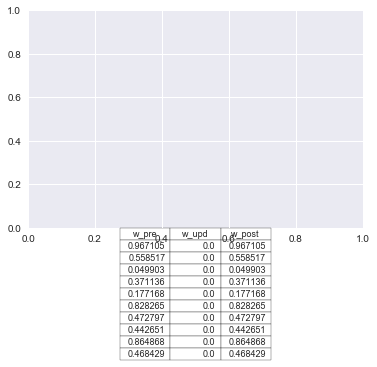

In [165]:
plt.figure()
tind = 15
table_data = np.array([np.squeeze((data_s[s][tind])) for s in ['w', 'w_upd', 'w_post']]).T
plt.table(cellText=table_data, colLabels=['w_pre', 'w_upd', 'w_post'], colWidths=[*3*[0.15]], fontsize=25)

In [126]:
tmp = Tempotron(1.5, 1e-4)
tmp.accuracy(stims, labels)
tmp.train(stims, labels, iter_num=1000, batch_size=50, train_mode='batch')
tmp.accuracy(stims, labels)

0.5

In [56]:
stim_a = np.random.binomial(2, .05, size=(10, 500))
stim_b = np.random.binomial(2, .05, size=(10, 500))
both = np.array([*500*[stim_a], *500*[stim_b]])
labels = np.array([*500 * [False], *500 * [True]])
randinds = np.random.choice(range(1000), replace=False, size=1000)
both = both[randinds]
labels = labels[randinds]
tmp.accuracy(both, labels)
tmp.train(both, labels, iter_num=30, train_mode='single')
tmp.accuracy(both, labels)

1.0

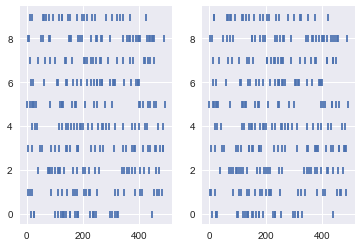

In [129]:
plt.subplot(121)
plot_stim(stims[0])
plt.subplot(122)
plot_stim(stims[2])

In [ ]:
# f, axarr = plt.subplots(3,3,figsize=(16,16))
# ax1 = 
def plot_trial(tr_data, xdata, model, trial, samp_num, *args, **kwargs):
    # add the following:
    # info on sample number and iter number
    # whether or or not the sample is in the batch
    # include w_trial, w_upd, and w_post, display as table under single figure on the right hand (3+4+5)
    f = plt.figure(*args, **kwargs)
    ax1 = plt.subplot2grid((8,8), (0, 0), colspan=6, rowspan=2)
    ax1.set_yticks([])
    ax2 = plt.subplot2grid((8,8), (2,0), colspan=6, rowspan=6)
    ax3 = plt.subplot2grid((8,8), (0, 6), rowspan=1, colspan=2)
#     ax3 = plt.subplot2grid((8,8), (0, 6), rowspan=1, colspan=2)
#     ax4 = plt.subplot2grid((8,8), (1, 6), rowspan=7, colspan=1)
#     ax5 = plt.subplot2grid((8,8), (1, 7), rowspan=7, colspan=1)
    axes = [ax1, ax2, ax3]


    # data for given x
    td = {model.x: rand_trains[samp_num][np.newaxis,], model.y_: rand_labels[samp_num][np.newaxis,]}
    trial_h = tr_data['w'][trial] @ rand_trains[samp_num]
    ax2.plot(range(t), trial_h)
    ax2.hlines(model.threshold_value,0,t, colors='r')

    plt.sca(ax1)
    plot_stim(xdata[samp_num])
    ax1.set_xticklabels([])
    def make_wtable(data, ax, *args, **kwargs):
        
        table_data = np.array([np.squeeze((data[s])) for s in ['w', 'w_upd', 'w_post']]).T
        plt.table(cellText=table_data, colLabels=['w_pre', 'w_upd', 'w_post'], colWidths=[*3*[0.15]], fontsize=25)
    
    def make_table(data, header, ax, *args, **kwargs):
        ax.text(0.4,.85,header, fontsize=18)
        ax.axis('off')
        for i,l in enumerate(np.arange(0.8,0.8-0.05*10, -0.05)):
            ax.text(.35, l, data[i])

    def display_info(ylab, ytag, ax):
        ax.axis('off')
        ylab, ytag = np.squeeze([ylab, ytag])
        c = 'green' if ylab == ytag else 'red'
        ax.text(0.35, 0.5, 'Y', fontsize=24)
        ax.text(0.25, 0.05, '{}'.format(ylab), fontsize=20, color=c)
        ax.text(0.85, 0.5, "Y'", fontsize=24)
        ax.text(0.75, 0.05, "{}".format((ytag)), fontsize=20, color=c)
        # Add accuracy and sample info

    yval = (trial_h > thresh).any()
    display_info(yval, model.y_.eval(td), ax3)
#     make_table2(tr_data, ax3)
#     make_table(tr_data['w'][trial], 'w', ax4)
#     make_table(tr_data['w_upd'][trial], 'w_upd', ax5)
    
    return f, axes

def grab_trial(data, trial):
    tr_data = [data[key][trial] for key in data]
    return tr_data

tr_data = grab_trial(data_s, 51)
f, axarr = plot_trial(data_s, rand_trains, tmp, 51, 51, figsize=(16,16))

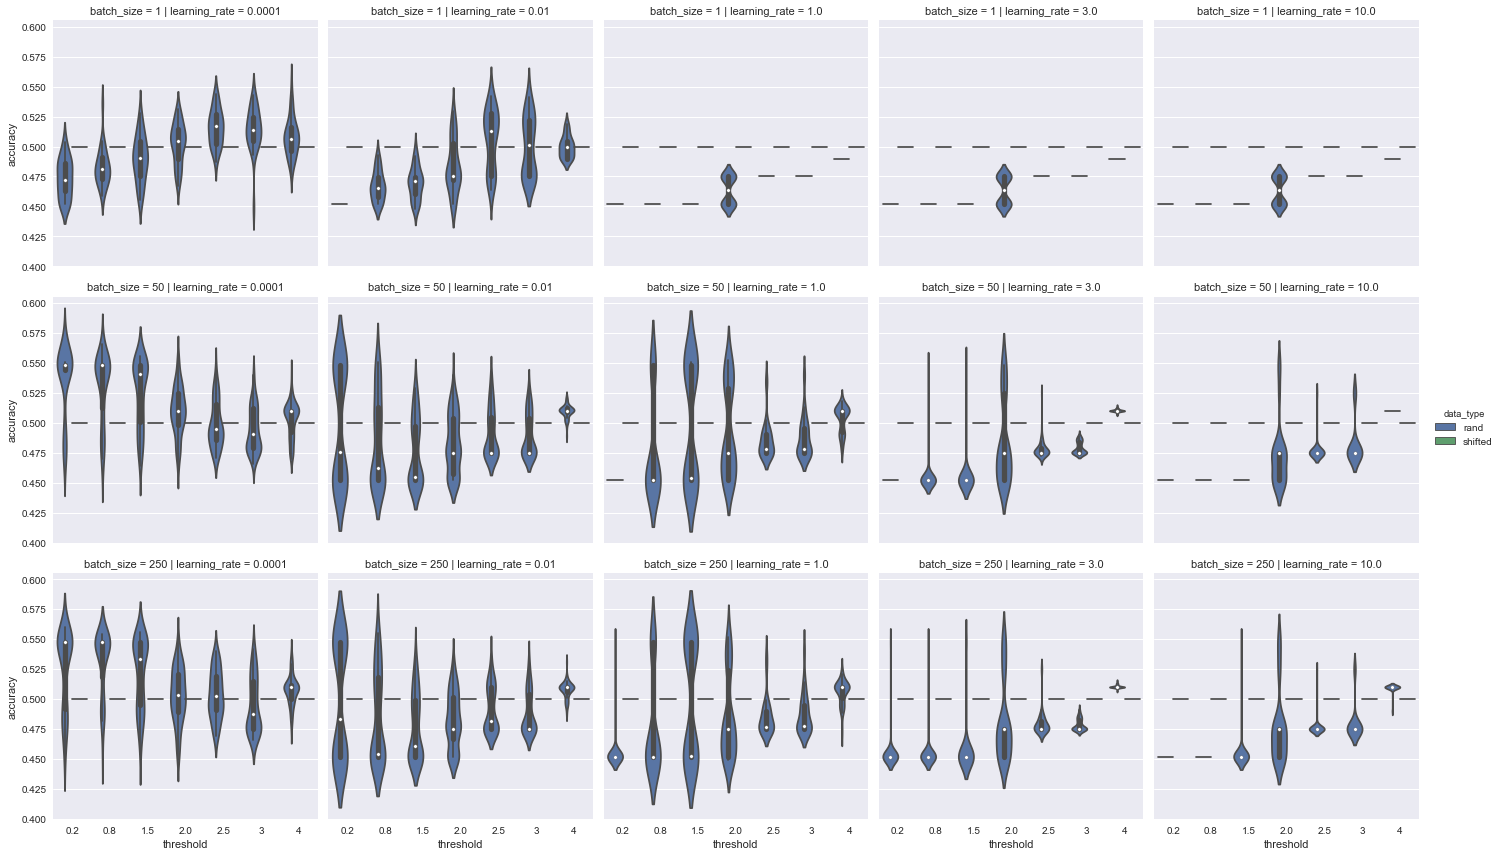

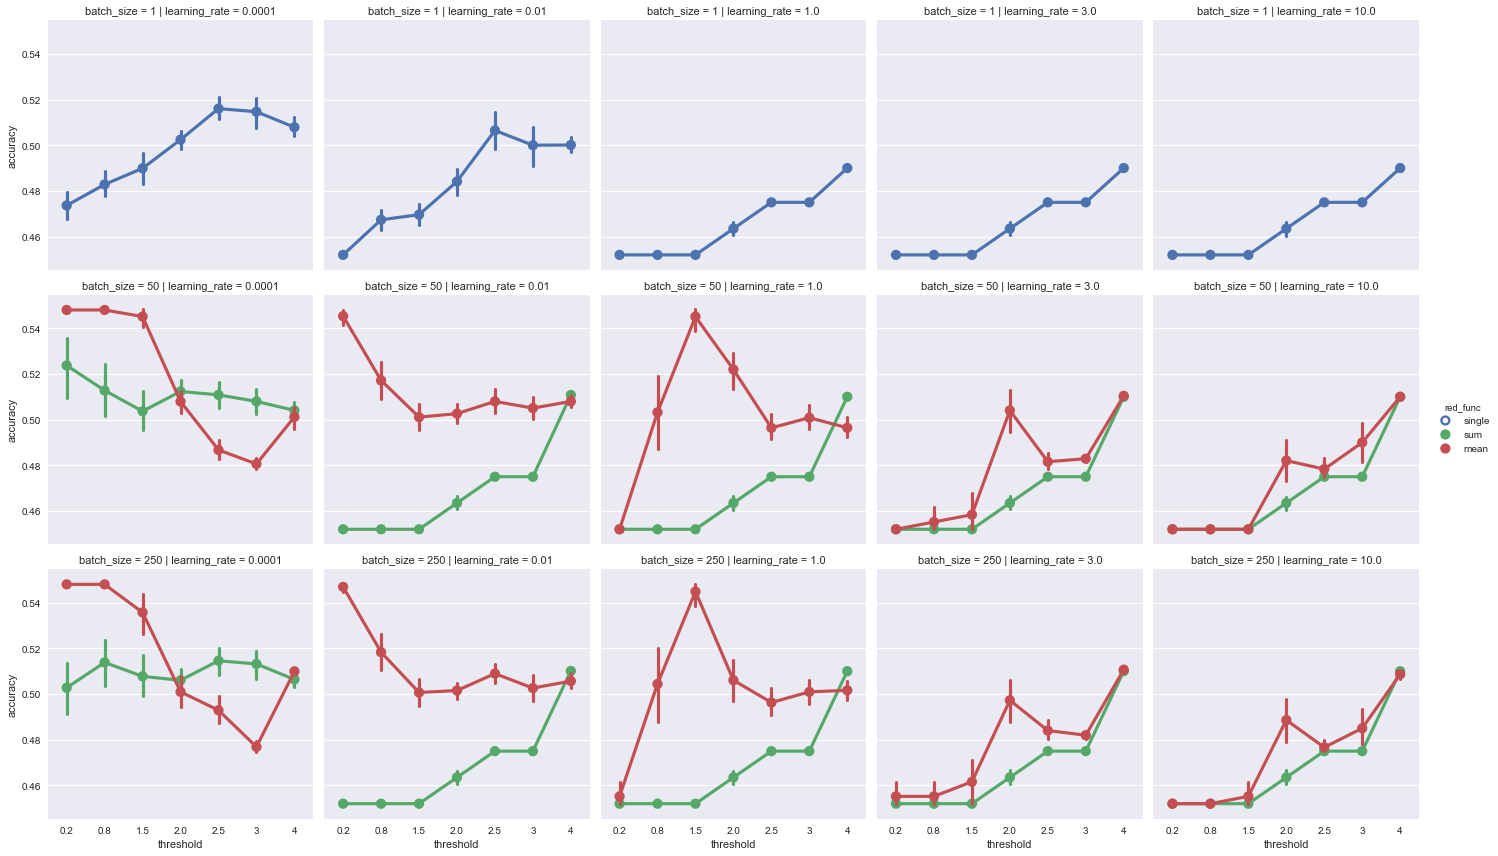

In [75]:
pre_df = test_data['pre']
post_df = test_data['post']
plt.figure(figsize=(16,16))
# sns.boxplot(data=pre_df, x='threshold', y='accuracy', hue='data_type');
sns.factorplot(data=post_df, y='accuracy', x='threshold', col='learning_rate',
               row='batch_size', hue='data_type', kind='violin')
partial = post_df[post_df['data_type'] == 'rand']
sns.factorplot(data=partial, y='accuracy', x='threshold', col='learning_rate',
               row='batch_size', hue='red_func', kind='point');

In [97]:
data = data={'rand': [rand_trains, rand_labels],'shifted': [stims, labels]}
def multi_cond_test(data):
    thresholds = [0.2, 0.8, 1.5, 2, 2.5, 3, 4]
    learning_rates = [1e-4, 1e-2, 1, 3, 10]
    red_funcs = ['sum', 'mean']
    train_modes = ['single', 'batch']
    batch_sizes = [50, 250]
    iter_batch = 1000
    iter_single = 100
    global_reps = 30
    

    pre_cnames = ['accuracy', 'threshold', 'data_type']
    post_cnames = ['accuracy', 'threshold', 'learning_rate', 
                   'red_func', 'train_mode', 'batch_size', 'data_type']
    pre_df = pd.DataFrame(columns=pre_cnames)
    post_df = pd.DataFrame(columns=post_cnames)
    for t,l in product(thresholds, learning_rates):
        for tm in train_modes:
            for dt in data:
                if tm == 'single':
                    print('Running {} data using {} mode training with: Thresh={:.3f}, lambda={:.4f}'.format(dt, tm, t, l))
                    tmp = Tempotron(t, l)

                    print('Before:   ', end='')
                    acc_pre = []
                    for i in range(global_reps):
                        print('\b\b{:2d}'.format(i), end='')
                        tmp.initvals()
                        curr_acc = tmp.accuracy(*data[dt])
                        acc_pre.append(curr_acc)
                        row = [curr_acc, t, dt]
                        pre_df.loc[pre_df.shape[0]] = row
                    print('   |  Total accuracy: {:.3%} ± {:.3%}'.format(np.mean(acc_pre), np.std(acc_pre, ddof=0)))

                    print('After:   ', end='')
                    acc_post = []
                    for i in range(global_reps):
                        print('\b\b{:2d}'.format(i), end='')
                        tmp.initvals()
                        tmp.train(*data[dt], iter_single, train_mode=tm)
                        curr_acc = tmp.accuracy(*data[dt])
                        acc_post.append(curr_acc)
                        row = [curr_acc, t, l, tm, tm, 1, dt]
                        post_df.loc[post_df.shape[0]] = row

                    print('   |  Total accuracy: {:.3%} ± {:.3%}'.format(np.mean(acc_post), np.std(acc_post, ddof=0)))

                if tm == 'batch':
                    for rf, bsz in product(red_funcs, batch_sizes):
                        print('Running {} data using {} mode training with: Thresh={:.3f}, lambda={:.4f}, batch_size={}, reduce_func={}'.format(dt, tm, t, l, bsz, rf))
                        tmp = Tempotron(t, l, reduce_func=rf)

                        print('Before:   ', end='')
                        acc_pre = []
                        for i in range(global_reps):
                            print('\b\b{:2d}'.format(i), end='')
                            tmp.initvals()
                            curr_acc = tmp.accuracy(*data[dt])
                            acc_pre.append(curr_acc)
                            row = [curr_acc, t, dt]
                            pre_df.loc[pre_df.shape[0]] = row
                        print('   |  Total accuracy: {:.3%} ± {:.3%}'.format(np.mean(acc_pre), np.std(acc_pre, ddof=0)))

                        print('After:   ', end='')
                        acc_post = []
                        for i in range(global_reps):
                            print('\b\b{:2d}'.format(i), end='')
                            tmp.initvals()
                            tmp.train(*data[dt], iter_single, train_mode=tm)
                            curr_acc = tmp.accuracy(*data[dt])
                            acc_post.append(curr_acc)
                            row = [curr_acc, t, l, rf, tm, bsz, dt]
                            post_df.loc[post_df.shape[0]] = row
                        print('   |  Total accuracy: {:.3%} ± {:.3%}'.format(np.mean(acc_post), np.std(acc_post, ddof=0)))
    test_data = {'pre': pre_df, 'post': post_df}
    return test_data


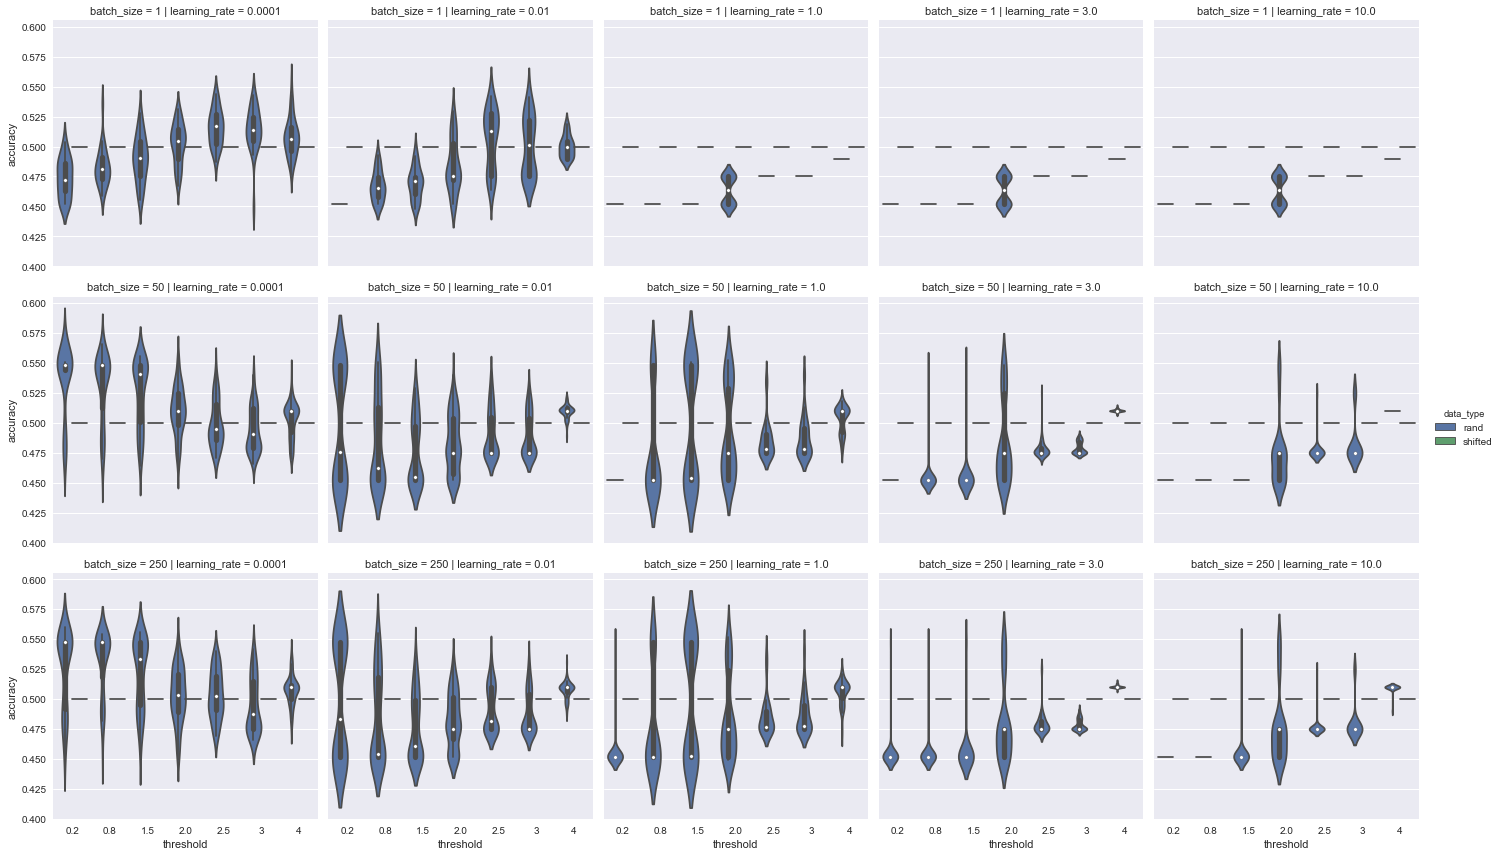

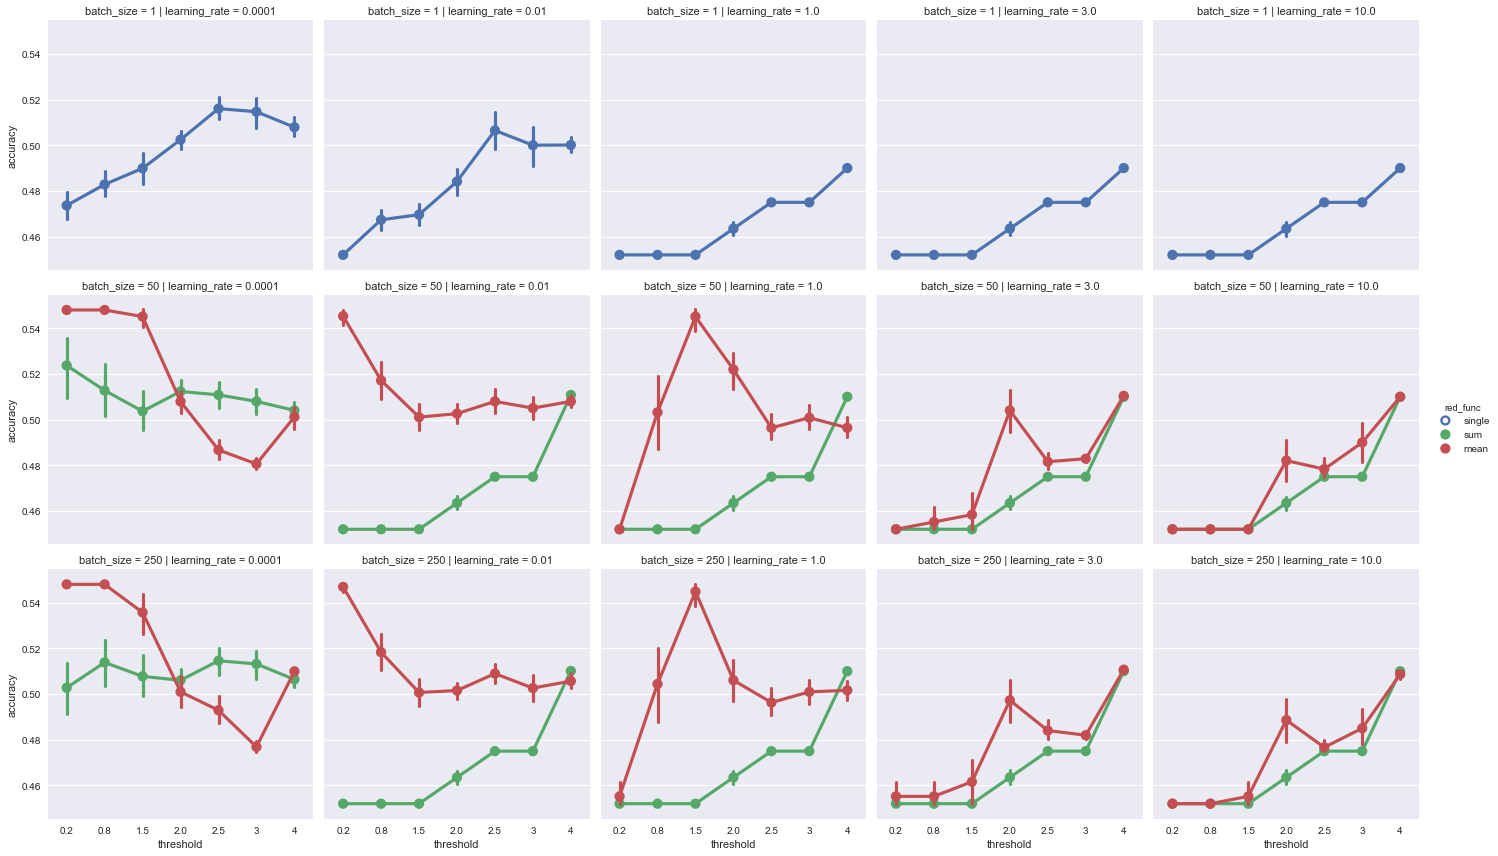

In [75]:
pre_df = test_data['pre']
post_df = test_data['post']
plt.figure(figsize=(16,16))
# sns.boxplot(data=pre_df, x='threshold', y='accuracy', hue='data_type');
sns.factorplot(data=post_df, y='accuracy', x='threshold', col='learning_rate',
               row='batch_size', hue='data_type', kind='violin')
partial = post_df[post_df['data_type'] == 'rand']
sns.factorplot(data=partial, y='accuracy', x='threshold', col='learning_rate',
               row='batch_size', hue='red_func', kind='point');

In [ ]:
def test_thresholds(data, thresholds = np.linspace(0, 4, 50), reps=30):
    runtime_vars = {'threshold': [],
                    'accuracy': [],
                   'weights': [],
                   'h': [],
                   'h_t': [],
                   'y': [],
                   'correct': []}
    for i,t in enumerate(thresholds):
        tmp = tempotron(t, 1e-4)
        tmp.thresh = tf.constant(t, dtype=tf.float32)
        print('Threshold={:.4f}, at {:.2%} progress.  '.format(tmp.thresh.eval(), (i+1) / len(thresholds)), end='')
        for var in runtime_vars:
            runtime_vars[var].append([])
        runtime_vars['threshold'][i] = t
        for j in range(reps):
            tmp.initvals()
            print('\b\b{:2d}'.format(j+1), end='')
            fd = {tmp.x: data[0], tmp.y_: data[1]}
            runtime_vars['accuracy'][i].append(tmp.accuracy(*data))
            runtime_vars['weights'][i].append(tmp.w.eval())
            runtime_vars['h'][i].append(tmp.h.eval(fd))
            runtime_vars['h_t'][i].append(tmp.h_t.eval(fd))
            runtime_vars['y'][i].append(tmp.y.eval(fd))
            runtime_vars['correct'][i].append(tmp.correct.eval(fd))
        print('  Finished | Accuracy : {:.2%} ± {:.2%}'.format(np.mean(runtime_vars['accuracy'][i]),
                                                               np.std(runtime_vars['accuracy'][i], ddof=0)))
    return runtime_vars


In [ ]:
# Trying to figure out the expected value at nodes of layer h to fine tune thresholding
from scipy.special import comb, factorial
freq = 50 # The random trains were generated with this frequency
timelength = 500 # The random trains were generated with this duration

# Probability of firing during single time instance for single neuron
p = freq * (timelength / 1000) / timelength

# Probability of 0 to n neurons firing in a single time instance
probs = [comb(n, i) * (p ** i) * ((1 - p) ** (n - i)) for i in range(n + 1)]

# Current weights are drawn from uniform(0, 1) and as such their initial mean should be 0.5
# Deriving strength of activation for 0 to n neurons firing
vals = np.multiply(0.5, range(n+1))

# Calculating expected value of neuron at layer h
np.multiply(probs, vals).sum()


In [ ]:
n_shifted = 500
shiftlen = 5

rand_inpdata = gen_random_trains(freq=50, m=1000, shape=(n, t))
sim_inpdata = make_basic_shifted(
    *rand_inpdata[0][np.random.choice(range(n_shifted*2), 2)], shiftlen, n_shifted)

varnames = ['w', 'h', 'h_t', 'y', 'correct']
tmp = tempotron(2.4, 1e-5)
fd = {tmp.x: sim_inpdata[0], tmp.y_: sim_inpdata[1]}
print('Before training:  \n')
print('Weights: ', tmp.w.eval())
print('Accuracy: ', tmp.accuracy(*sim_inpdata))
params_pre = {var: getattr(tmp, var).eval(None if var=='w' else fd) for var in varnames}
tmp.train(rand_trains, rand_labels, 300)
print('\nAfter training \n')
print('Weights: ', tmp.w.eval())
print('Accuracy: ', tmp.accuracy(*sim_inpdata))
params_post = {var: getattr(tmp, var).eval(None if var=='w' else fd) for var in varnames}

In [ ]:
# runtime_data = test_thresholds(sim_inpdata)
# plt.figure(figsize=(12, 12))
# sns.distplot(np.random.choice(np.array(runtime_data['h']).flatten(), 10000), hist=False);
# np.array(runtime_data['h']).mean()

In [ ]:
# plt.figure(figsize=(12, 12))
# sns.distplot(np.random.choice(np.array(runtime_data['h']).flatten(), 10000), hist=False);


In [ ]:
# np.array(runtime_data['h']).mean()

In [ ]:
params = [[0.5, 1e-4], [0.5, 5],
         [4, 1e-4], [4, 1e-4]]
batch_size = 250
for p in params:
    print('Params = {}'.format(p))
    tmp = tempotron(*p)
    d = []
    cz = []
    wz = []
    for i in range(50):
        print('{}'.format(i), end='\r')
        tmp.initvals()
        wz.append([])
        cz.append([])

        c_pre = tmp.accuracy(rand_trains, rand_labels)
        wz[i].append(tmp.w.eval())
        cz[i].append(c_pre)

        tmp.train(rand_trains, rand_labels, batch_size)

        c_post = tmp.accuracy(rand_trains, rand_labels)
        wz[i].append(tmp.w.eval())
        cz[i].append(c_post)

        d.append(c_post - c_pre)
    print(np.mean(d))

In [ ]:
import pickle

In [ ]:
fd = {tmp.x: sim_inpdata[0], tmp.y_: sim_inpdata[1]}
tmp.initvals()
yz=tmp.y.eval(fd)
c=tmp.correct.eval(fd)
hz=tmp.h.eval(fd)
h_tz=tmp.h_t.eval(fd)

In [ ]:
with open('debug_data.pickle', 'wb')  as f:
    pickle.dump(runtime_data, f, protocol=pickle.HIGHEST_PROTOCOL)

Attempt at reworking stimulus generation using brian2, create 2 stimuli, and from each generate a set of N shifted samples

In [139]:
import brian2 as b2
from brian2.units import ms, Hz, second
import pyspike as spk

def brian_poisson(Rate, Duration, Refractory=2*ms, dt=1*ms, n=1):
    Q = b2.units.fundamentalunits.Quantity
    if not isinstance(Rate, Q):
        if np.isscalar(Rate):
            Rate = Rate * Hz
        else:
            Rate = np.array(Rate) * Hz
    if not isinstance(Duration, Q):
        if np.isscalar(Duration):
            Duration = Duration * second
        else:
            Duration = np.array(Duration) * second
    Neuron = b2.NeuronGroup(n, 'rate : Hz', threshold='rand()<rate*dt', dt=dt)
    Neuron.rate = Rate
    Spikes = b2.SpikeMonitor(Neuron, record=True)
    b2.run(Duration)
    if n == 1:
        Trains = Spikes.spike_trains()[0] / dt
    else:
        Trains = [train / dt for train in Spikes.spike_trains().values()]
    return Trains

brian_duration = 0.5 * second
stimset_a = brian_poisson(50, brian_duration, n=10)
stimset_b = brian_poisson(50, brian_duration, n=10)
duration = int(brian_duration / ms)

def booleanize(tr_set):
    booled = []
    tr_len = duration
    for train in tr_set:
        curr_tr = np.zeros(tr_len)
        curr_tr[train.astype(int)] = 1
        booled.append(curr_tr)
    return np.array(booled)

def shiftset(tr_set, shift_size, num_shifted):
    train_lens = [len(tr) for tr in tr_set]
    all_shifted = []
    for _ in range(num_shifted):
        curr_shifted = []
        for tr in tr_set:
            vals = np.random.randint(shift_size + 1, size=tr.size)
            new_tr =  tr + vals
            edge = np.greater_equal(tr + shift_size, duration)
            if edge.any():
                edge_vals = tr[edge]
                deltas = duration - edge_vals
                for i in range(np.size(edge_vals)):
                    edge_vals[i] += np.random.randint(deltas[i])
                new_tr[edge] = edge_vals
            curr_shifted.append(new_tr)
        all_shifted.append(curr_shifted)
    return all_shifted

setsize = 500
shift_size = 5
shifted_a = shiftset(stimset_a, shift_size, setsize)
shifted_b = shiftset(stimset_b, shift_size, setsize)

shifted_a = np.array([booleanize(tr_set) for tr_set in shifted_a])
shifted_b = np.array([booleanize(tr_set) for tr_set in shifted_b])

shifted_all = np.concatenate([shifted_a, shifted_b])
labels = np.concatenate([np.zeros(setsize), np.ones(setsize)])

randinds = np.random.choice(np.arange(len(labels)), size=len(labels), replace=False)

shifted_all = shifted_all[randinds]
labels = labels[randinds]

In [144]:
# Run this for the shifted data
thresh = 2
learning_rate = 1e-4
tmp = Tempotron(thresh, learning_rate)
tmp.reduce_func = tf.reduce_mean
data_all = tmp.train(shifted_all, labels, train_mode='batch', return_params=True)
tmp.initvals()
data_50 = tmp.train(shifted_all, labels, batch_size=50, return_params=True)
tmp.initvals()
data_s = tmp.train(shifted_all, labels, iter_num=50, train_mode='single', return_params=True)